In [21]:
# Load Hidden states
import torch
tensor_fw_avg = torch.load('language_translate_fw_avg_output_sample2.pth')
tensor_bw_avg = torch.load('language_translate_bw_avg_output_sample2.pth')

## Load Data
import pandas as pd
csv_file_path = 'language_translate_fw_output_sample2.csv'
data = pd.read_csv(csv_file_path, header=0)
languages = data['3'].unique()
types = data[data['3'] == languages[0]]['1'].values
print(types)
print(data.columns)

[2 2 3 1 1 3]
Index(['0', '1', '2', '3', '4', '5'], dtype='object')


In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, latent_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(model, inputs, target, num_epochs = 20, lr_=0.001):
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_)

    losses = []  # List to store losses for plotting
    for epoch in range(num_epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)  # Compute the reconstruction loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Store loss for plotting
        losses.append(loss.item())
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(tensor_fw_avg)}")

    # print("Finished Training")
    return losses

def get_error(model, inputs, targets):
    criterion = nn.MSELoss(reduction='none')
    running_loss = 0.0
    outputs = model(inputs)
    loss = criterion(outputs, targets)  # Compute the reconstruction loss
    # print('loss:', loss.shape)
    loss_2_sum = torch.sum(loss, 1) / loss.shape[1]
    # print('loss_2_sum:', loss_2_sum.shape)
    outputs_sum = torch.sum(outputs, 1) #/ outputs.shape[1]
    # print('outputs_sum:', outputs_sum.shape)
    targets_sum = torch.sum(targets, 1) #/ targets.shape[1]
    # print('targets_sum:', targets_sum.shape)
    errors = loss_2_sum / (outputs_sum * targets_sum)
    # print('errors:', errors.shape)
    return torch.abs(errors)
    # return errors


In [23]:
import numpy as np
import pandas as pd

input_size = tensor_fw_avg.shape[1]  # Size of vectors
losses_all = {}
num_epochs = 300
latents = np.arange(8, 64, 8)
# latents = [64, 32]
matrices = np.empty((0, 5))
for lang in languages:
    for latent_size in latents:
        index = list(data[data['3'] == lang].index)
        fw = tensor_fw_avg[index]
        fw = torch.tensor(fw, requires_grad=True)
        bw = tensor_bw_avg[index]
        bw = torch.tensor(bw, requires_grad=True)

        model = Autoencoder(input_size, latent_size)
        losses = train_autoencoder(model, fw, bw, num_epochs=num_epochs)
        losses_all[lang + ' (hid=' + str(latent_size) + ')'] = losses

        errors = get_error(model, fw, bw).detach().numpy()
        ids = list(range(errors.shape[0]))
        langs = np.repeat(lang, errors.shape[0])
        latent_sizes = np.repeat(latent_size, errors.shape[0]) / fw.shape[1]
        matrix = np.vstack((ids, types, langs, errors, latent_sizes))
        matrices = np.concatenate((matrices, matrix.T), axis=0)
# print(losses_all)

<ipython-input-23-2102cc3248cc>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fw = torch.tensor(fw, requires_grad=True)
<ipython-input-23-2102cc3248cc>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bw = torch.tensor(bw, requires_grad=True)


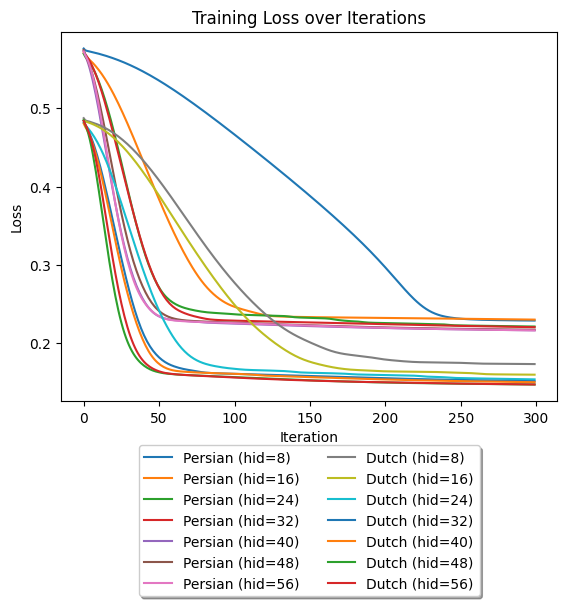

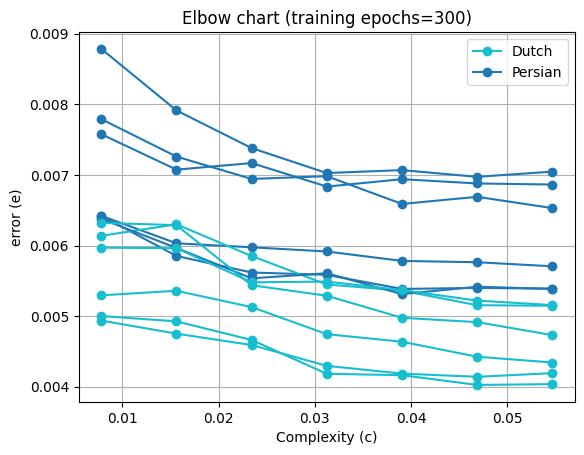

    0  1        2         3         4
0   0  2  Persian  0.006421  0.007812
1   1  2  Persian  0.006421  0.007812
2   2  3  Persian  0.007791  0.007812
3   3  1  Persian  0.006378  0.007812
4   4  1  Persian  0.008785  0.007812
.. .. ..      ...       ...       ...
79  1  2    Dutch  0.004344  0.054688
80  2  3    Dutch  0.005148  0.054688
81  3  1    Dutch  0.004037  0.054688
82  4  1    Dutch  0.004732  0.054688
83  5  3    Dutch  0.005157  0.054688

[84 rows x 5 columns]


In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_error(losses, title):
    for key, value in losses.items():
        plt.plot(value, label=key)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
    plt.savefig('loss.png', bbox_inches='tight')
    plt.show()

def plot_elbow(dataframe, title='Elbow chart'):
    # Get unique categories
    unique_categories = np.unique(dataframe[2].unique())
    num_categories = len(unique_categories)

    # Define a colormap with enough distinct colors
    cmap = plt.get_cmap('tab10', num_categories)
    norm = mcolors.Normalize(vmin=0, vmax=num_categories - 1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    scatter_plots = {}
    for id in dataframe[0].unique():
        if True: #id == 0:
            for i, lang in enumerate(dataframe[2].unique()):
                if True: #lang == 'Persian':
                    df = dataframe[(dataframe[0] == id) & (dataframe[2] == lang)]

                    data = {'X': df[4].values,
                            'Y': df[3].values}
                    df = pd.DataFrame(data)

                    filter = df.sort_values(by='X')
                    # plt.scatter(filter[4].values, filter[3].values, color=cmap(i))
                    scatter_plots[lang], = plt.plot(filter['X'], filter['Y'],
                                                    linestyle='-', marker='o',
                                                    color=cmap(i), label=lang)

    plt.xlabel('Complexity (c)')
    plt.ylabel('error (e)')
    plt.title(title)
    plt.legend(handles=[scatter_plots[cat] for cat in unique_categories])
    plt.grid(True)
    plt.savefig('elbow.png')
    plt.show()

plot_error(losses_all, 'Training Loss over Iterations')
df_matrices = pd.DataFrame(matrices)
df_matrices[0] = df_matrices[0].astype(int)
df_matrices[1] = df_matrices[1].astype(int)
df_matrices[2] = df_matrices[2].astype(str)
df_matrices[3] = df_matrices[3].astype(float)
df_matrices[4] = df_matrices[4].astype(float)
plot_elbow(df_matrices, 'Elbow chart (training epochs=%s)' % num_epochs)
print(df_matrices)

In [27]:
df_matrices.to_csv('elbow_avg_output_sample2.csv', index=False)